
📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



C:\Users\DELL\AppData\Local\Temp\ipykernel_16500\2062884605.py:226: RuntimeWarning: overflow encountered in exp
  return f0 + A / (1.0 + np.exp(s*(x - t)))


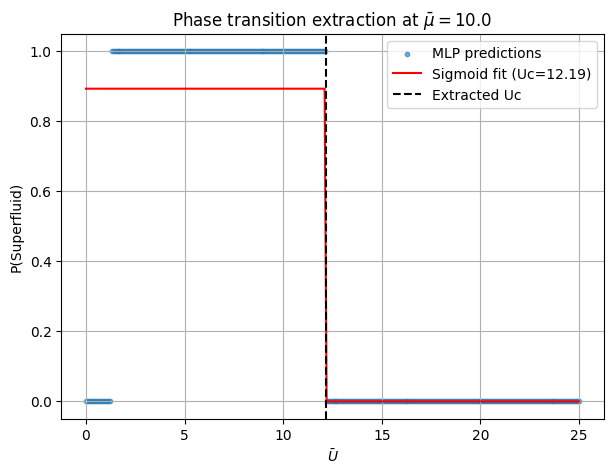

Extracted critical Uc at mu=10.00: 12.191583608611271


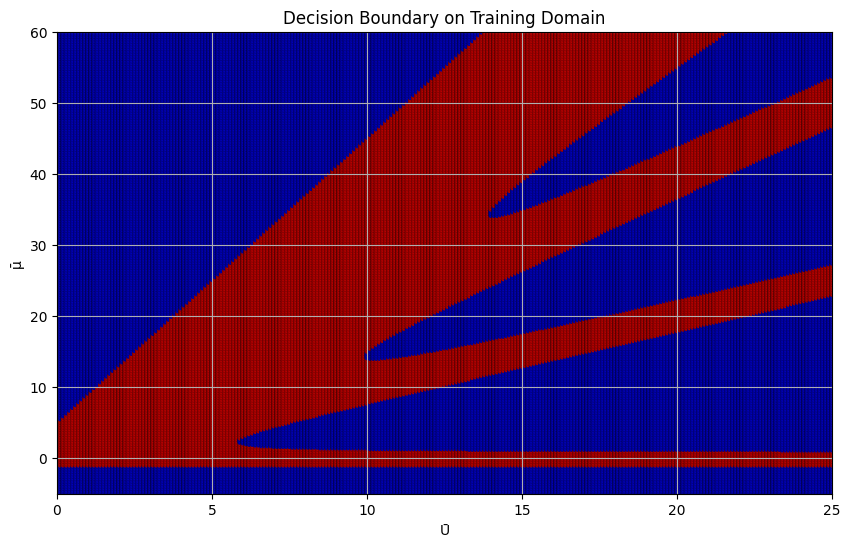

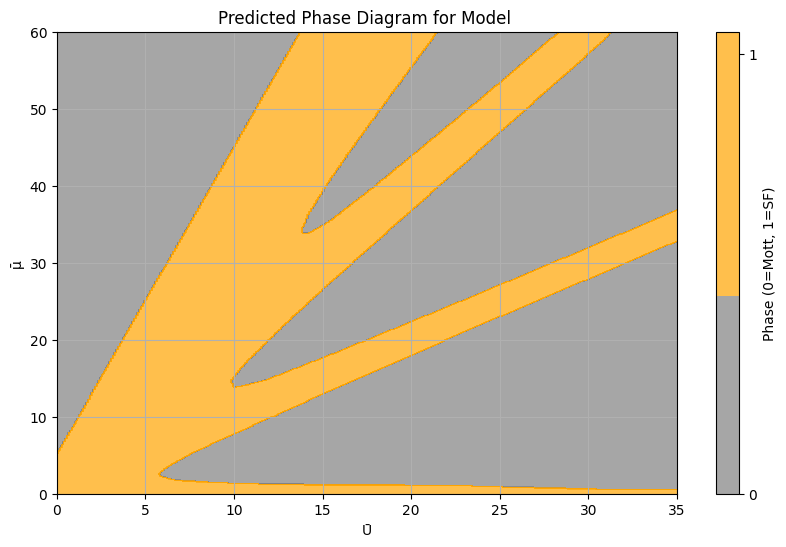


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9881    0.9986    0.9933     87410
           1     0.9981    0.9834    0.9907     63441

    accuracy                         0.9922    150851
   macro avg     0.9931    0.9910    0.9920    150851
weighted avg     0.9923    0.9922    0.9922    150851



In [2]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# Apply physics-based labeling
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Sigmoid function for fitting ---
def sigmoid(x, f0, A, s, t):
    """
    f0  = offset
    A   = amplitude
    s   = steepness
    t   = critical point (midpoint)
    """
    return f0 + A / (1.0 + np.exp(s*(x - t)))

# --- Function to sweep Ubar and fit sigmoid ---
def extract_transition(model, mu_fixed, U_min=0.0, U_max=25.0, step=0.1):
    # Sweep Ubar at fixed mu
    U_vals = np.arange(U_min, U_max+step, step)
    X_sweep = pd.DataFrame({"Ubar": U_vals, "Mubar": [mu_fixed]*len(U_vals)})
    
    # Predict probability of SF
    y_probs = model.predict(X_sweep)
    if y_probs.ndim > 1:  # if shape (N,1)
        y_probs = y_probs.ravel()
    
    # Fit sigmoid
    try:
        popt, _ = curve_fit(sigmoid, U_vals, y_probs,
                            p0=[0.0, 1.0, 1.0, np.median(U_vals)],
                            maxfev=10000)
        f0, A, s, Uc = popt
    except RuntimeError:
        print(f"⚠️ Sigmoid fit failed at mu={mu_fixed}")
        return None, U_vals, y_probs, None
    
    return Uc, U_vals, y_probs, popt
    
# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))

# --- Plot one example ---
mu_fixed = 10.0   # choose some chemical potential slice
Uc, U_vals, y_probs, popt = extract_transition(models["MLP"], mu_fixed)

plt.figure(figsize=(7,5))
plt.scatter(U_vals, y_probs, s=10, alpha=0.6, label="MLP predictions")
if popt is not None:
    plt.plot(U_vals, sigmoid(U_vals, *popt), 'r-', label=f"Sigmoid fit (Uc={Uc:.2f})")
plt.axvline(Uc, color="k", linestyle="--", label="Extracted Uc")
plt.xlabel(r"$\bar U$")
plt.ylabel("P(Superfluid)")
plt.title(fr"Phase transition extraction at $\bar \mu={mu_fixed}$")
plt.legend()
plt.grid(True)
plt.show()

print(f"Extracted critical Uc at mu={mu_fixed:.2f}: {Uc}")

    
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



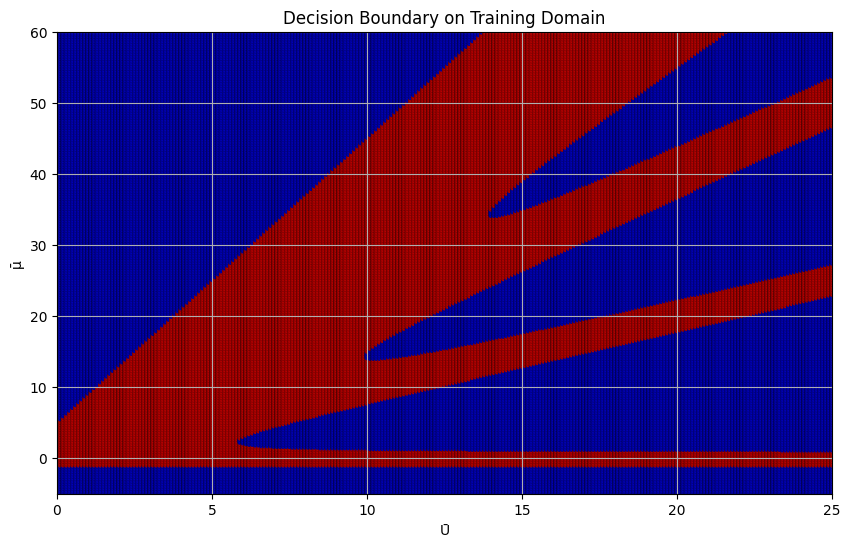

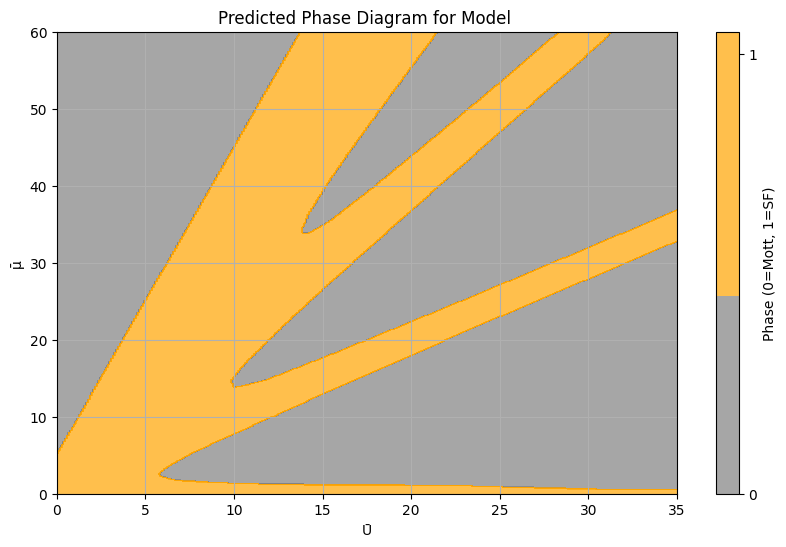


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9881    0.9986    0.9933     87410
           1     0.9981    0.9834    0.9907     63441

    accuracy                         0.9922    150851
   macro avg     0.9931    0.9910    0.9920    150851
weighted avg     0.9923    0.9922    0.9922    150851



In [4]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)


# Apply physics-based labeling
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)


# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# print( " Initial Data", df)

# # --- pick extremes ---
# df_extremes = df[
#     ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
#     | (df["Phi2"] > 1e-2)  # deep SF
# ]

# # --- pick near-boundary points ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
# ]

# # --- sample safely ---
# n_ext = min(2000, len(df_extremes))
# n_bnd = min(5000, len(df_boundary))

# df_reduced = pd.concat([
#     df_extremes.sample(n_ext, random_state=42),
#     df_boundary.sample(n_bnd, random_state=42)
# ])

# # Use this reduced datase
# df = df_reduced.reset_index(drop=True)

# print("extreme datapoints  (reduced dataset)",df)


# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # --- Sigmoid function for fitting ---
# def sigmoid(x, f0, A, s, t):
#     """
#     f0  = offset
#     A   = amplitude
#     s   = steepness
#     t   = critical point (midpoint)
#     """
#     return f0 + A / (1.0 + np.exp(s*(x - t)))

# # --- Function to sweep Ubar and fit sigmoid ---
# def extract_transition(model, mu_fixed, U_min=0.0, U_max=25.0, step=0.1):
#     # Sweep Ubar at fixed mu
#     U_vals = np.arange(U_min, U_max+step, step)
#     X_sweep = pd.DataFrame({"Ubar": U_vals, "Mubar": [mu_fixed]*len(U_vals)})
    
#     # Predict probability of SF
#     y_probs = model.predict(X_sweep)
#     if y_probs.ndim > 1:  # if shape (N,1)
#         y_probs = y_probs.ravel()
    
#     # Fit sigmoid
#     try:
#         popt, _ = curve_fit(sigmoid, U_vals, y_probs,
#                             p0=[0.0, 1.0, 1.0, np.median(U_vals)],
#                             maxfev=10000)
#         f0, A, s, Uc = popt
#     except RuntimeError:
#         print(f"⚠️ Sigmoid fit failed at mu={mu_fixed}")
#         return None, U_vals, y_probs, None
    
#     return Uc, U_vals, y_probs, popt
    
# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))

# # --- Plot one example ---
# mu_fixed = 10.0   # choose some chemical potential slice
# Uc, U_vals, y_probs, popt = extract_transition(models["MLP"], mu_fixed)

# plt.figure(figsize=(7,5))
# plt.scatter(U_vals, y_probs, s=10, alpha=0.6, label="MLP predictions")
# if popt is not None:
#     plt.plot(U_vals, sigmoid(U_vals, *popt), 'r-', label=f"Sigmoid fit (Uc={Uc:.2f})")
# plt.axvline(Uc, color="k", linestyle="--", label="Extracted Uc")
# plt.xlabel(r"$\bar U$")
# plt.ylabel("P(Superfluid)")
# plt.title(fr"Phase transition extraction at $\bar \mu={mu_fixed}$")
# plt.legend()
# plt.grid(True)
# plt.show()

# print(f"Extracted critical Uc at mu={mu_fixed:.2f}: {Uc}")

    
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))

In [ ]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)


# Apply physics-based labeling
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)


# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# print( " Initial Data", df)

# # --- pick extremes ---
# df_extremes = df[
#     ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
#     | (df["Phi2"] > 1e-2)  # deep SF
# ]

# # --- pick near-boundary points ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
# ]

# # --- sample safely ---
# n_ext = min(2000, len(df_extremes))
# n_bnd = min(5000, len(df_boundary))

# df_reduced = pd.concat([
#     df_extremes.sample(n_ext, random_state=42),
#     df_boundary.sample(n_bnd, random_state=42)
# ])

# # Use this reduced datase
# df = df_reduced.reset_index(drop=True)

# print("extreme datapoints  (reduced dataset)",df)


# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # --- Sigmoid function for fitting ---
# def sigmoid(x, f0, A, s, t):
#     """
#     f0  = offset
#     A   = amplitude
#     s   = steepness
#     t   = critical point (midpoint)
#     """
#     return f0 + A / (1.0 + np.exp(s*(x - t)))

# # --- Function to sweep Ubar and fit sigmoid ---
# def extract_transition(model, mu_fixed, U_min=0.0, U_max=25.0, step=0.1):
#     # Sweep Ubar at fixed mu
#     U_vals = np.arange(U_min, U_max+step, step)
#     X_sweep = pd.DataFrame({"Ubar": U_vals, "Mubar": [mu_fixed]*len(U_vals)})
    
#     # Predict probability of SF
#     y_probs = model.predict(X_sweep)
#     if y_probs.ndim > 1:  # if shape (N,1)
#         y_probs = y_probs.ravel()
    
#     # Fit sigmoid
#     try:
#         popt, _ = curve_fit(sigmoid, U_vals, y_probs,
#                             p0=[0.0, 1.0, 1.0, np.median(U_vals)],
#                             maxfev=10000)
#         f0, A, s, Uc = popt
#     except RuntimeError:
#         print(f"⚠️ Sigmoid fit failed at mu={mu_fixed}")
#         return None, U_vals, y_probs, None
    
#     return Uc, U_vals, y_probs, popt
    
# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))

# # --- Plot one example ---
# mu_fixed = 10.0   # choose some chemical potential slice
# Uc, U_vals, y_probs, popt = extract_transition(models["MLP"], mu_fixed)

# plt.figure(figsize=(7,5))
# plt.scatter(U_vals, y_probs, s=10, alpha=0.6, label="MLP predictions")
# if popt is not None:
#     plt.plot(U_vals, sigmoid(U_vals, *popt), 'r-', label=f"Sigmoid fit (Uc={Uc:.2f})")
# plt.axvline(Uc, color="k", linestyle="--", label="Extracted Uc")
# plt.xlabel(r"$\bar U$")
# plt.ylabel("P(Superfluid)")
# plt.title(fr"Phase transition extraction at $\bar \mu={mu_fixed}$")
# plt.legend()
# plt.grid(True)
# plt.show()

# print(f"Extracted critical Uc at mu={mu_fixed:.2f}: {Uc}")

    
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))

Reduced dataset shape: (2684, 8)


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9887    0.9038    0.9443       291
           1     0.9309    0.9921    0.9605       380

    accuracy                         0.9538       671
   macro avg     0.9598    0.9479    0.9524       671
weighted avg     0.9560    0.9538    0.9535       671



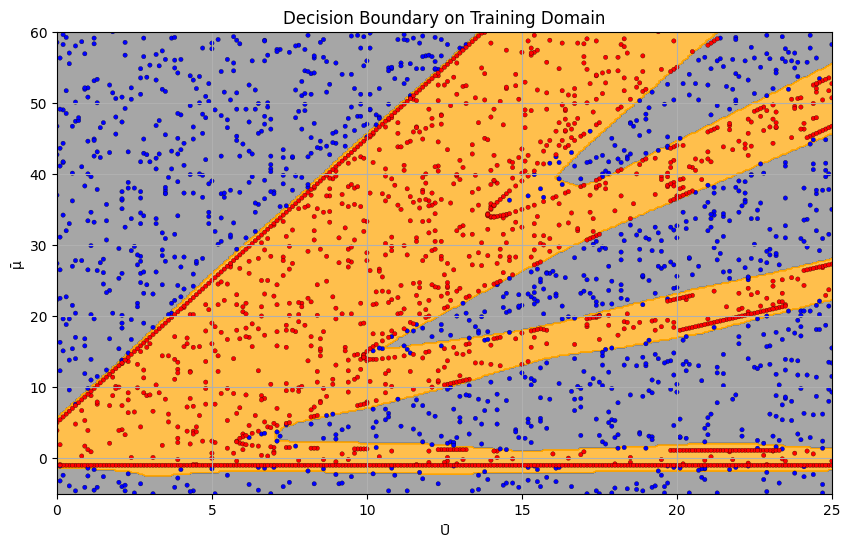

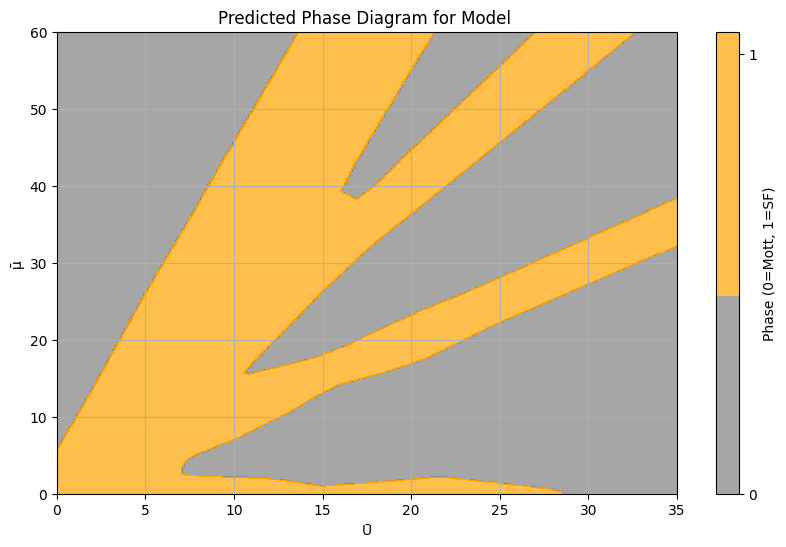


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9849    0.9315    0.9575      1051
           1     0.9445    0.9879    0.9657      1241

    accuracy                         0.9620      2292
   macro avg     0.9647    0.9597    0.9616      2292
weighted avg     0.9630    0.9620    0.9619      2292



In [5]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# --- pick extremes (deep MI and deep SF) ---
df_extremes = df[
    ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
    | (df["Phi2"] > 1e-2)  # deep SF
]

# --- pick near-boundary points ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
]

# --- sample safely ---
n_ext = min(2000, len(df_extremes))
n_bnd = min(5000, len(df_boundary))

df_reduced = pd.concat([
    df_extremes.sample(n_ext, random_state=42),
    df_boundary.sample(n_bnd, random_state=42)
])

# Use reduced dataset
df = df_reduced.reset_index(drop=True)

print("Reduced dataset shape:", df.shape)

# ---------- 2) Define features + target ----------
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# ---------- 3) Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)



# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# print( " Initial Data", df)

# # --- pick extremes ---
# df_extremes = df[
#     ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
#     | (df["Phi2"] > 1e-2)  # deep SF
# ]

# # --- pick near-boundary points ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
# ]

# # --- sample safely ---
# n_ext = min(2000, len(df_extremes))
# n_bnd = min(5000, len(df_boundary))

# df_reduced = pd.concat([
#     df_extremes.sample(n_ext, random_state=42),
#     df_boundary.sample(n_bnd, random_state=42)
# ])

# # Use this reduced datase
# df = df_reduced.reset_index(drop=True)

# print("extreme datapoints  (reduced dataset)",df)


# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # --- Sigmoid function for fitting ---
# def sigmoid(x, f0, A, s, t):
#     """
#     f0  = offset
#     A   = amplitude
#     s   = steepness
#     t   = critical point (midpoint)
#     """
#     return f0 + A / (1.0 + np.exp(s*(x - t)))

# # --- Function to sweep Ubar and fit sigmoid ---
# def extract_transition(model, mu_fixed, U_min=0.0, U_max=25.0, step=0.1):
#     # Sweep Ubar at fixed mu
#     U_vals = np.arange(U_min, U_max+step, step)
#     X_sweep = pd.DataFrame({"Ubar": U_vals, "Mubar": [mu_fixed]*len(U_vals)})
    
#     # Predict probability of SF
#     y_probs = model.predict(X_sweep)
#     if y_probs.ndim > 1:  # if shape (N,1)
#         y_probs = y_probs.ravel()
    
#     # Fit sigmoid
#     try:
#         popt, _ = curve_fit(sigmoid, U_vals, y_probs,
#                             p0=[0.0, 1.0, 1.0, np.median(U_vals)],
#                             maxfev=10000)
#         f0, A, s, Uc = popt
#     except RuntimeError:
#         print(f"⚠️ Sigmoid fit failed at mu={mu_fixed}")
#         return None, U_vals, y_probs, None
    
#     return Uc, U_vals, y_probs, popt
    
# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))

# # --- Plot one example ---
# mu_fixed = 10.0   # choose some chemical potential slice
# Uc, U_vals, y_probs, popt = extract_transition(models["MLP"], mu_fixed)

# plt.figure(figsize=(7,5))
# plt.scatter(U_vals, y_probs, s=10, alpha=0.6, label="MLP predictions")
# if popt is not None:
#     plt.plot(U_vals, sigmoid(U_vals, *popt), 'r-', label=f"Sigmoid fit (Uc={Uc:.2f})")
# plt.axvline(Uc, color="k", linestyle="--", label="Extracted Uc")
# plt.xlabel(r"$\bar U$")
# plt.ylabel("P(Superfluid)")
# plt.title(fr"Phase transition extraction at $\bar \mu={mu_fixed}$")
# plt.legend()
# plt.grid(True)
# plt.show()

# print(f"Extracted critical Uc at mu={mu_fixed:.2f}: {Uc}")

    
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))

# 10k reduced dataset ( larger than before)

Reduced dataset summary:
Phase
1    2684
0    2000
Name: count, dtype: int64
Reduced dataset shape: (4684, 8)

📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     1.0000    0.9280    0.9627       500
           1     0.9491    1.0000    0.9739       671

    accuracy                         0.9693      1171
   macro avg     0.9745    0.9640    0.9683      1171
weighted avg     0.9708    0.9693    0.9691      1171



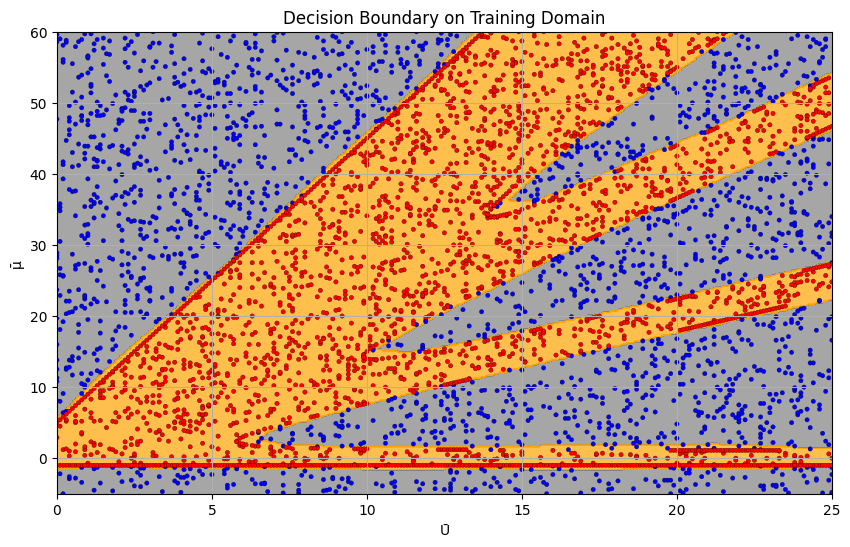

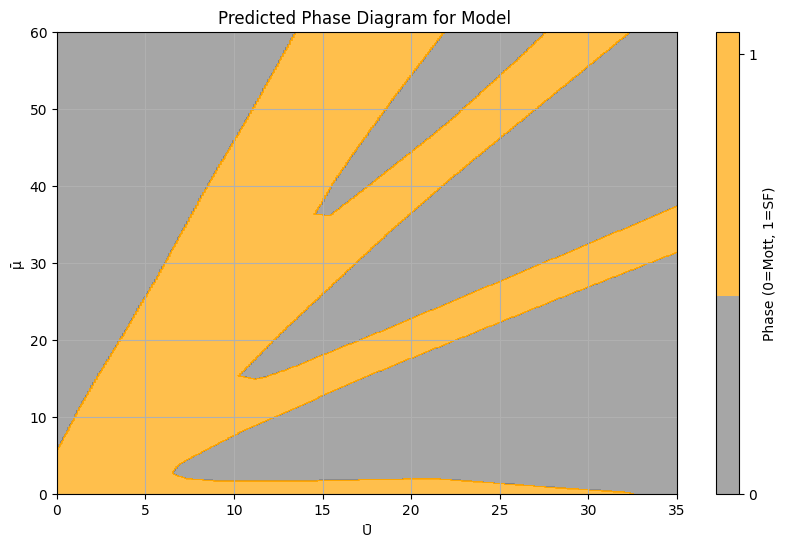


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     1.0000    0.9539    0.9764      1799
           1     0.9663    1.0000    0.9829      2381

    accuracy                         0.9801      4180
   macro avg     0.9832    0.9769    0.9796      4180
weighted avg     0.9808    0.9801    0.9801      4180



In [7]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- pick extremes (deep MI and deep SF) ---
# df_extremes = df[
#     ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
#     | (df["Phi2"] > 1e-2)  # deep SF
# ]

# # --- pick near-boundary points ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
# ]

# # --- sample safely ---
# n_ext = min(2000, len(df_extremes))
# n_bnd = min(5000, len(df_boundary))

# df_reduced = pd.concat([
#     df_extremes.sample(n_ext, random_state=42),
#     df_boundary.sample(n_bnd, random_state=42)
# ])

# # Use reduced dataset
# df = df_reduced.reset_index(drop=True)

# print("Reduced dataset shape:", df.shape)

# # ---------- 2) Define features + target ----------
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---
df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])

df_reduced = df_reduced.reset_index(drop=True)

print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())
# Use reduced dataset
df = df_reduced.reset_index(drop=True)

print("Reduced dataset shape:", df.shape)

# ---------- 2) Define features + target ----------
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# ---------- 3) Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)



# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# print( " Initial Data", df)

# # --- pick extremes ---
# df_extremes = df[
#     ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
#     | (df["Phi2"] > 1e-2)  # deep SF
# ]

# # --- pick near-boundary points ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
# ]

# # --- sample safely ---
# n_ext = min(2000, len(df_extremes))
# n_bnd = min(5000, len(df_boundary))

# df_reduced = pd.concat([
#     df_extremes.sample(n_ext, random_state=42),
#     df_boundary.sample(n_bnd, random_state=42)
# ])

# # Use this reduced datase
# df = df_reduced.reset_index(drop=True)

# print("extreme datapoints  (reduced dataset)",df)


# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # --- Sigmoid function for fitting ---
# def sigmoid(x, f0, A, s, t):
#     """
#     f0  = offset
#     A   = amplitude
#     s   = steepness
#     t   = critical point (midpoint)
#     """
#     return f0 + A / (1.0 + np.exp(s*(x - t)))

# # --- Function to sweep Ubar and fit sigmoid ---
# def extract_transition(model, mu_fixed, U_min=0.0, U_max=25.0, step=0.1):
#     # Sweep Ubar at fixed mu
#     U_vals = np.arange(U_min, U_max+step, step)
#     X_sweep = pd.DataFrame({"Ubar": U_vals, "Mubar": [mu_fixed]*len(U_vals)})
    
#     # Predict probability of SF
#     y_probs = model.predict(X_sweep)
#     if y_probs.ndim > 1:  # if shape (N,1)
#         y_probs = y_probs.ravel()
    
#     # Fit sigmoid
#     try:
#         popt, _ = curve_fit(sigmoid, U_vals, y_probs,
#                             p0=[0.0, 1.0, 1.0, np.median(U_vals)],
#                             maxfev=10000)
#         f0, A, s, Uc = popt
#     except RuntimeError:
#         print(f"⚠️ Sigmoid fit failed at mu={mu_fixed}")
#         return None, U_vals, y_probs, None
    
#     return Uc, U_vals, y_probs, popt
    
# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))

# # --- Plot one example ---
# mu_fixed = 10.0   # choose some chemical potential slice
# Uc, U_vals, y_probs, popt = extract_transition(models["MLP"], mu_fixed)

# plt.figure(figsize=(7,5))
# plt.scatter(U_vals, y_probs, s=10, alpha=0.6, label="MLP predictions")
# if popt is not None:
#     plt.plot(U_vals, sigmoid(U_vals, *popt), 'r-', label=f"Sigmoid fit (Uc={Uc:.2f})")
# plt.axvline(Uc, color="k", linestyle="--", label="Extracted Uc")
# plt.xlabel(r"$\bar U$")
# plt.ylabel("P(Superfluid)")
# plt.title(fr"Phase transition extraction at $\bar \mu={mu_fixed}$")
# plt.legend()
# plt.grid(True)
# plt.show()

# print(f"Extracted critical Uc at mu={mu_fixed:.2f}: {Uc}")

    
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))